In [171]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.2f' % x)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
import missingno as msno
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
import os

In [172]:
# Read CSV

cwd=os.getcwd()
df_=pd.read_csv(f'{cwd}/SydneyHousePrices.csv')
df = df_.copy()

In [173]:
# Check Dataframe

In [174]:
def check_df(dataframe):
    print("#"*20)
    print("#"*5,"HEAD","#"*5)
    print(df.head())
    print("#"*20)
    print("#"*5,"TAIL","#"*5)
    print(df.tail())
    print("#"*20)
    print("#"*5,"DESCRIBE","#"*5)
    print(df.describe().T)
    print("#"*20)
    print("#"*5,"INFO","#"*5)
    print(df.info())
    print("#"*20)
    print("#"*5,"NA CHECK","#"*5)
    print(df.isnull().sum())


In [175]:
check_df(df)

####################
##### HEAD #####
         Date  Id        suburb  postalCode  sellPrice  bed  bath  car  \
0  2019-06-19   1  Avalon Beach        2107    1210000 4.00     2 2.00   
1  2019-06-13   2  Avalon Beach        2107    2250000 4.00     3 4.00   
2  2019-06-07   3   Whale Beach        2107    2920000 3.00     3 2.00   
3  2019-05-28   4  Avalon Beach        2107    1530000 3.00     1 2.00   
4  2019-05-22   5   Whale Beach        2107    8000000 5.00     4 4.00   

  propType  
0    house  
1    house  
2    house  
3    house  
4    house  
####################
##### TAIL #####
              Date      Id         suburb  postalCode  sellPrice  bed  bath  \
199499  2014-06-20  199500       Illawong        2234    1900000 5.00     3   
199500  2014-05-26  199501       Illawong        2234     980000 4.00     3   
199501  2014-04-17  199502  Alfords Point        2234     850000 4.00     2   
199502  2013-09-07  199503       Illawong        2234     640000 3.00     2   
199503

In [176]:
df.drop(df.loc[df["sellPrice"] <= 100000].index, axis=0, inplace=True) 

In [177]:
df["propType"].unique()

array(['house', 'townhouse', 'duplex/semi-detached', 'villa', 'other',
       'terrace', 'warehouse', 'acreage'], dtype=object)

In [178]:
df["Date"]=pd.to_datetime(df["Date"])


In [179]:
df.drop("Id",axis=1, inplace=True)

In [180]:
df = df.loc[(df["postalCode"] >= 2000) & (df["postalCode"]<2600)]  # Sydney postal code is between 2000 and 2600.

In [181]:
df = df.loc[(df["propType"] != "other") & (df["propType"] != "warehouse")]

In [182]:
df.shape

(186601, 8)

In [183]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in df.columns if dataframe[col].dtypes=="O"]
    num_but_cat = [col for col in df.columns if (dataframe[col].nunique()<cat_th) and (dataframe[col].dtypes!="O")]
    cat_but_car = [col for col in dataframe.columns if (dataframe[col].nunique() > car_th) and (dataframe[col].dtypes == "O")]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in df.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    return cat_cols, num_cols, cat_but_car

In [184]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 186601
Variables: 8
cat_cols: 1
num_cols: 6
cat_but_car: 1
num_but_cat: 0


In [185]:
cat_cols

['propType']

In [186]:
num_cols

['Date', 'postalCode', 'sellPrice', 'bed', 'bath', 'car']

In [187]:
cat_but_car

['suburb']

In [188]:
num_cols.remove("postalCode")

In [189]:
num_cols

['Date', 'sellPrice', 'bed', 'bath', 'car']

In [190]:
# Check Outlier Thresholds

In [191]:
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [192]:
def check_outlier(dataframe, col_name, q1=0.01, q3=0.99):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name]<low_limit)|(dataframe[col_name]>up_limit)].any(axis=None):
        return True
    else:
        return False 

In [193]:
for i in num_cols:
    print(i, check_outlier(df,i))

Date False
sellPrice True
bed True
bath True
car True


In [194]:
def grab_outliers(dataframe, col_name, index=False):
    low, up= outlier_thresholds(dataframe,col_name)
    if dataframe[(dataframe[col_name]<low) | (dataframe[col_name]>up)].shape[0]>10:
        print ( dataframe[(dataframe[col_name]<low) | (dataframe[col_name]>up)].head())
    else:
        print ( dataframe[(dataframe[col_name]<low) | (dataframe[col_name]>up)])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [195]:
for i in num_cols:
    print(f"########### {i} ##########")
    print(grab_outliers(df,i))

########### Date ##########
Empty DataFrame
Columns: [Date, suburb, postalCode, sellPrice, bed, bath, car, propType]
Index: []
None
########### sellPrice ##########
            Date        suburb  postalCode  sellPrice  bed  bath  car propType
530   2012-10-19   Whale Beach        2107   13100000 6.00     4 5.00    house
830   2014-02-03    Clareville        2107   12000000 4.00     5 4.00    house
5572  2018-08-07   Queenscliff        2096   12000000 5.00     5 2.00    house
19165 2011-10-10  Wattle Grove        2173  431176576 4.00     2 2.00    house
26305 2016-07-14      Rose Bay        2029   12500000 5.00     5 2.00    house
None
########### bed ##########
            Date      suburb  postalCode  sellPrice   bed  bath   car propType
12345 2018-03-12  Kensington        2033    4600000 15.00    14 10.00    house
12476 2012-05-11  Kensington        2033    3000000 19.00     6  1.00    house
12534 2009-11-20  Kensington        2033    3300000 26.00    21 18.00    house
12632 2015-03

In [196]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


In [197]:
#Suppressing Outliers
for col in num_cols:
    replace_with_thresholds(df, col)

In [198]:
for i in num_cols:
    print(i, check_outlier(df,i))

Date False
sellPrice False
bed False
bath False
car False


In [199]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
postalCode,186601.00,2158.97,130.46,2000.00,2076.00,2137.00,2200.00,2574.00
sellPrice,186601.00,1276200.09,908587.71,105000.00,749500.00,1027000.00,1510000.00,11490000.00
bed,186516.00,3.51,1.02,1.00,3.00,3.00,4.00,12.00
bath,186601.00,1.90,0.89,1.00,1.00,2.00,2.00,11.00
car,169127.00,1.93,1.01,1.00,1.00,2.00,2.00,13.50


In [200]:
df["car"].value_counts()

2.00     85028
1.00     57788
3.00     14584
4.00      8261
5.00      1537
6.00      1158
8.00       253
7.00       230
10.00      119
9.00        68
13.50       44
12.00       35
11.00       14
13.00        8
Name: car, dtype: int64

In [201]:
df["car"] = df["car"].fillna(0) # When the data set is examined, 0 is assigned to this value, since it is understood that the NaN value is those with no cars.

In [202]:
df["car"].value_counts()

2.00     85028
1.00     57788
0.00     17474
3.00     14584
4.00      8261
5.00      1537
6.00      1158
8.00       253
7.00       230
10.00      119
9.00        68
13.50       44
12.00       35
11.00       14
13.00        8
Name: car, dtype: int64

In [203]:
df["car"] = df["car"].astype(int)

In [204]:
df.isnull().sum()

Date           0
suburb         0
postalCode     0
sellPrice      0
bed           85
bath           0
car            0
propType       0
dtype: int64

In [205]:
df = df.dropna(axis=0)

In [206]:
num_cols.remove("Date")

In [207]:
num_cols

['sellPrice', 'bed', 'bath', 'car']

In [208]:
# LOF

clf = LocalOutlierFactor(n_neighbors=20) # 20 burada komşuluk sayısıdır. Bunu değiştirebiliriz. 20 ön tanımlıdır ve tercih edilebilir.
clf.fit_predict(df[num_cols]) # Bununla skorları getiriyor olacak yani LOF skorlarını. 

df_scores = clf.negative_outlier_factor_ # Bu skorları tutuyoruz.

df_scores[0:5]

array([-1.00000000e+00, -9.97475305e-01, -1.03217235e+00, -1.00000000e+09,
       -9.89544849e-01])

In [209]:
np.sort(df_scores)

array([-3.25000002e+13, -3.00000005e+13, -3.00000005e+13, ...,
       -8.78370367e-01, -8.78370367e-01, -8.72495067e-01])

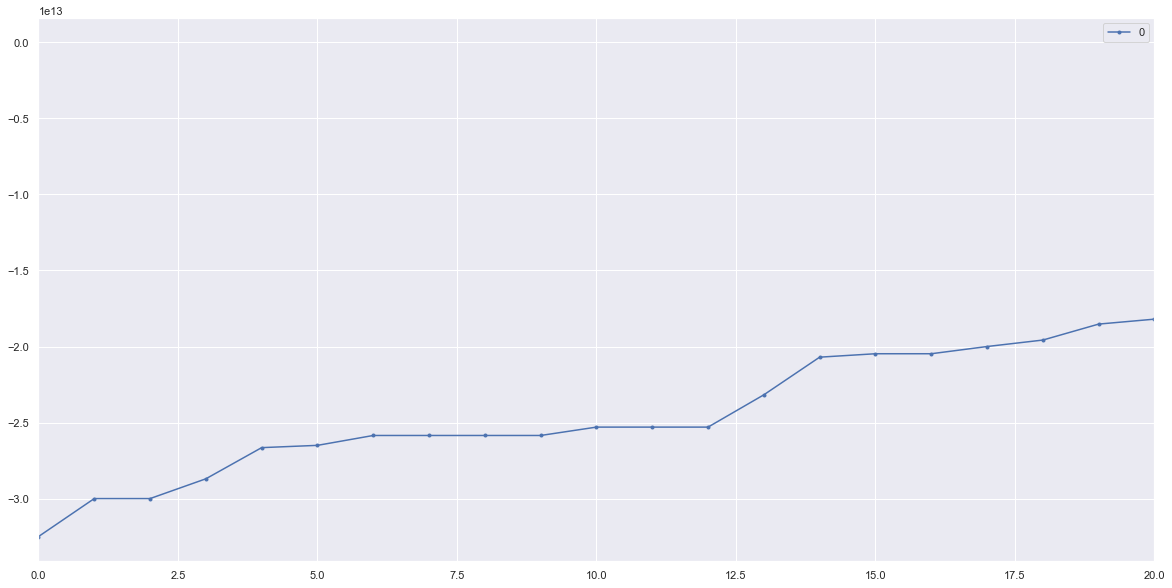

In [210]:
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 20], style='.-')
plt.show()  # Bu grafikten eşik değer belirlenebilir

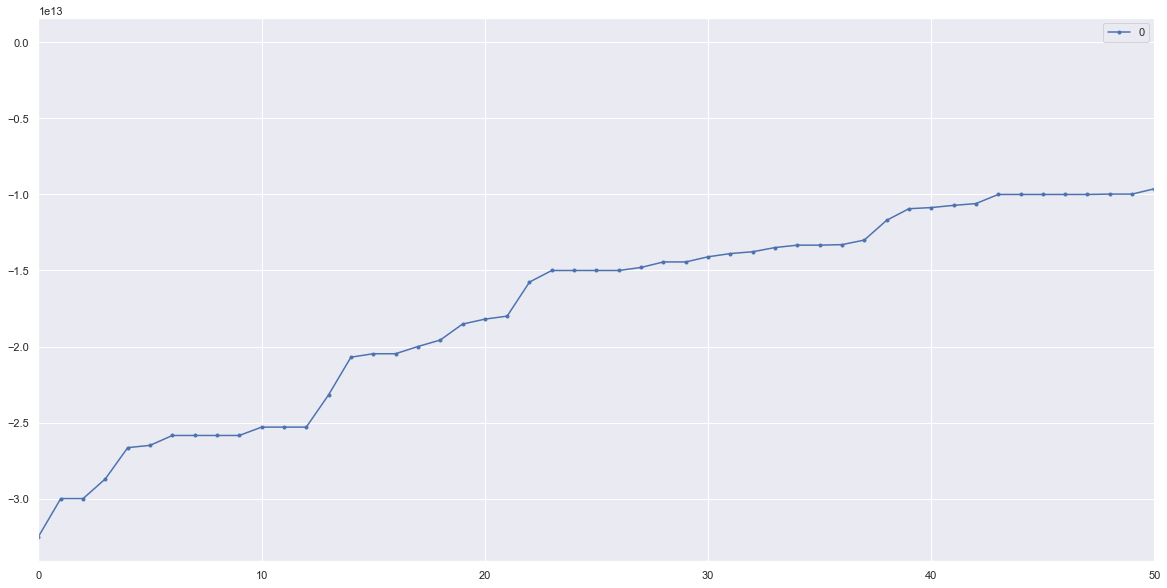

In [211]:
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.show()  

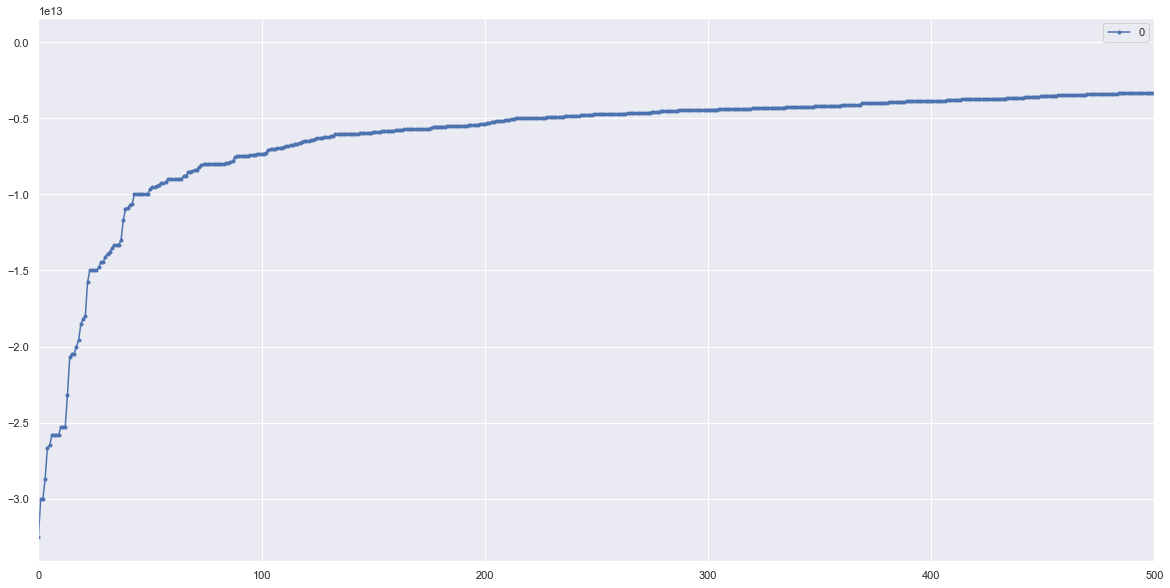

In [212]:
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 500], style='.-')
plt.show()  

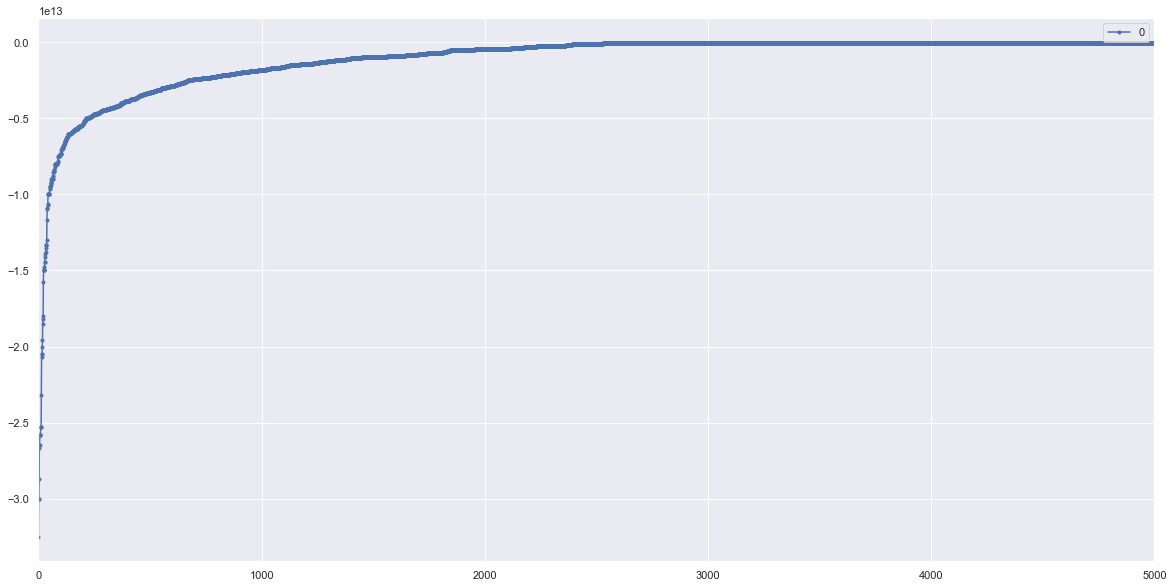

In [213]:
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 5000], style='.-')
plt.show()  

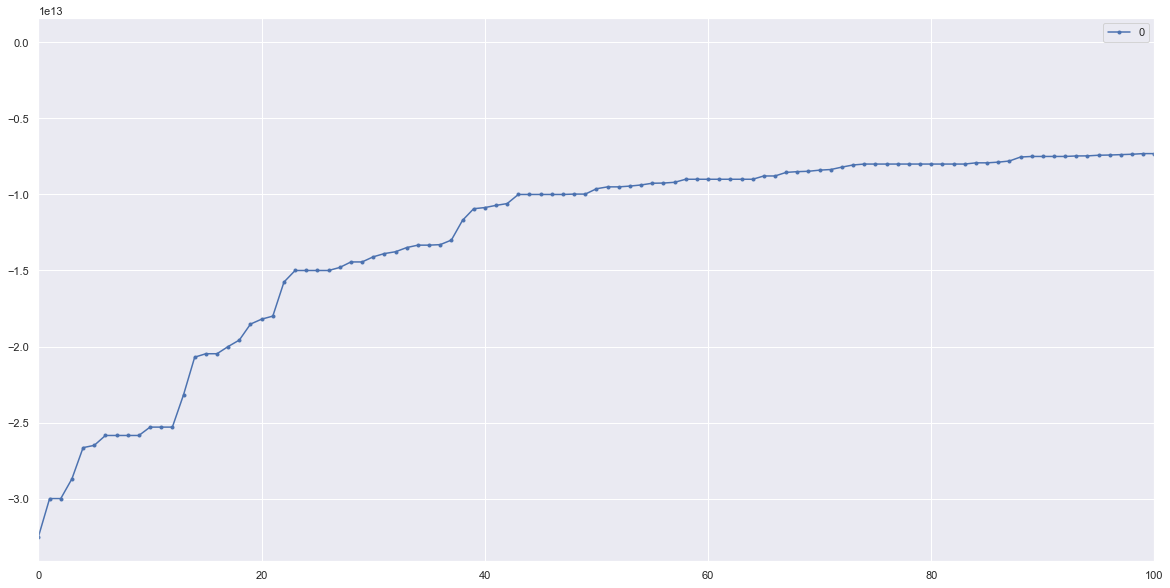

In [214]:
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 100], style='.-')
plt.show()  

In [215]:
# When the threshold value graph is examined,The second value is selected.

th = np.sort(df_scores)[2]

In [216]:
th

-30000000540635.586

In [217]:
df[df_scores<th].shape

(1, 8)

In [218]:
df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index, inplace=True)  

C:\Users\melih.oznalbant\AppData\Local\Temp\ipykernel_33240\197706345.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index, inplace=True)


In [219]:
df.shape

(186516, 8)

In [220]:
check_num_cols = ["bed","bath","car"]

In [221]:
for i in check_num_cols:
    print(df.groupby("propType").agg({i:["count","mean","sum"]}))

                         bed               
                       count mean       sum
propType                                   
acreage                   10 4.60     46.00
duplex/semi-detached    6568 3.42  22450.00
house                 158795 3.61 573277.00
terrace                 1334 2.98   3975.00
townhouse              14469 2.85  41247.00
villa                   5340 2.59  13837.00
                        bath             
                       count mean     sum
propType                                 
acreage                   10 2.70      27
duplex/semi-detached    6568 2.05   13488
house                 158795 1.92  305454
terrace                 1334 1.72    2299
townhouse              14469 1.81   26157
villa                   5340 1.40    7497
                         car             
                       count mean     sum
propType                                 
acreage                   10 3.40      34
duplex/semi-detached    6568 1.43    9399
house           

In [222]:
for i in check_num_cols:
    print(df.groupby(i).agg({"sellPrice":["count","mean","sum"]}))

      sellPrice                        
          count       mean          sum
bed                                    
1.00       1195  837205.45   1000460511
2.00      22476  890460.05  20013980150
3.00      77312 1061954.07  82101792866
4.00      58501 1396293.89  81684588673
5.00      21858 1896500.58  41453709603
6.00       3928 2263919.19   8892674594
7.00        725 2236176.54   1621227991
8.00        252 2276070.79    573569838
9.00         98 2420023.92    237162344
10.00        61 2341852.46    142853000
11.00        16 2560875.00     40974000
12.00        94 3018398.94    283729500
     sellPrice                        
         count       mean          sum
bath                                  
1        67561  948570.03  64086339470
2        80385 1220420.66  98103515047
3        30699 1715126.99  52652683473
4         5900 2638031.96  15564388558
5         1387 3667367.39   5086638570
6          378 4317626.39   1632062775
7          105 4811152.49    505171011
8         

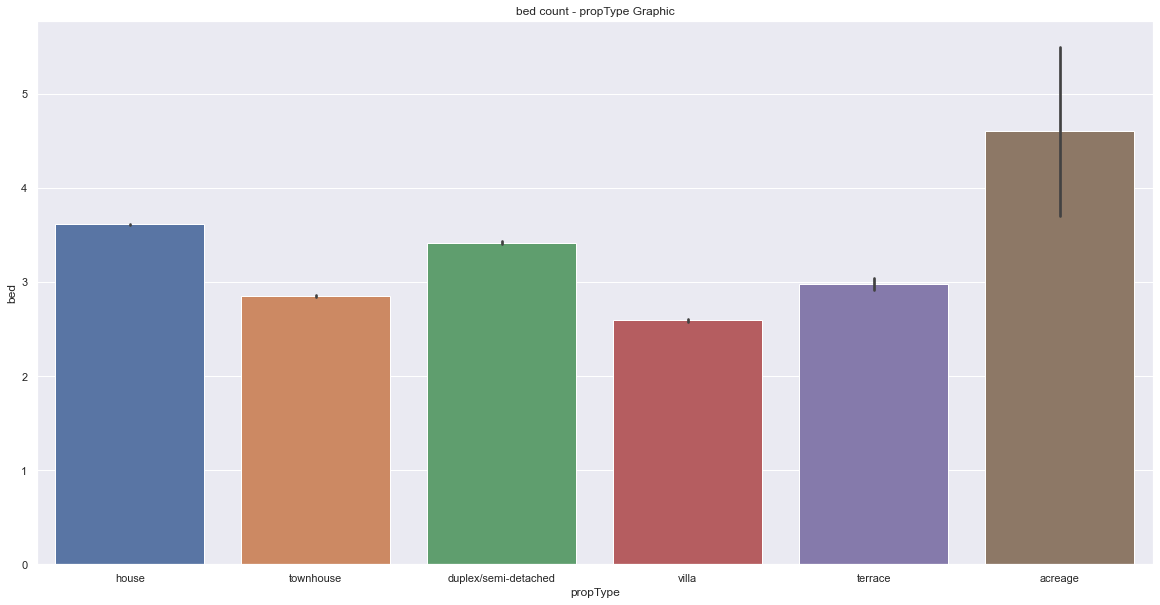

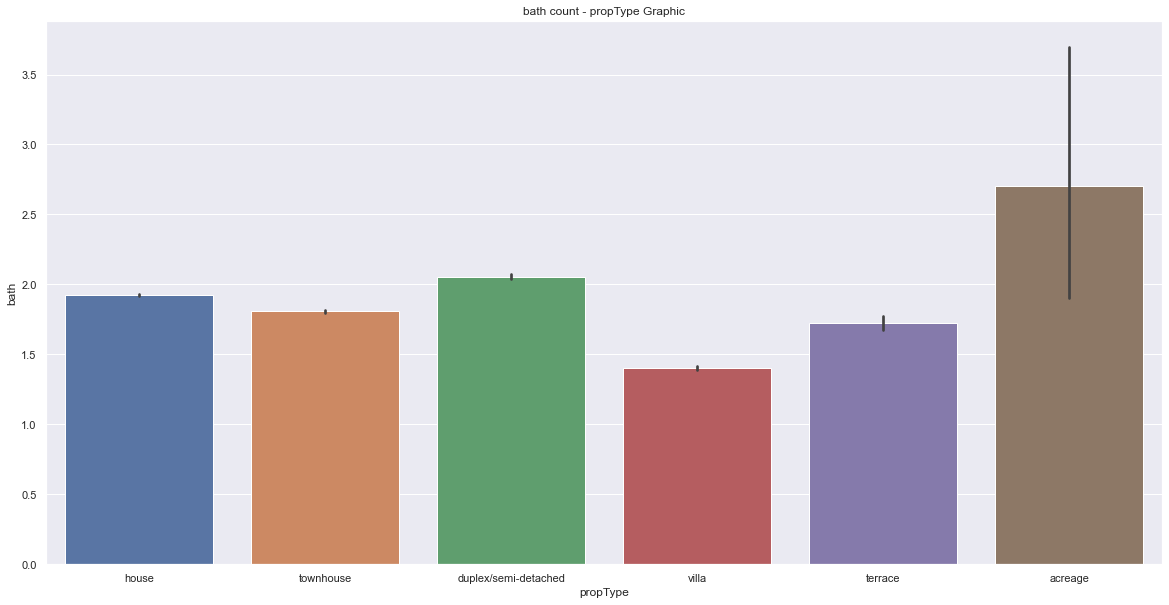

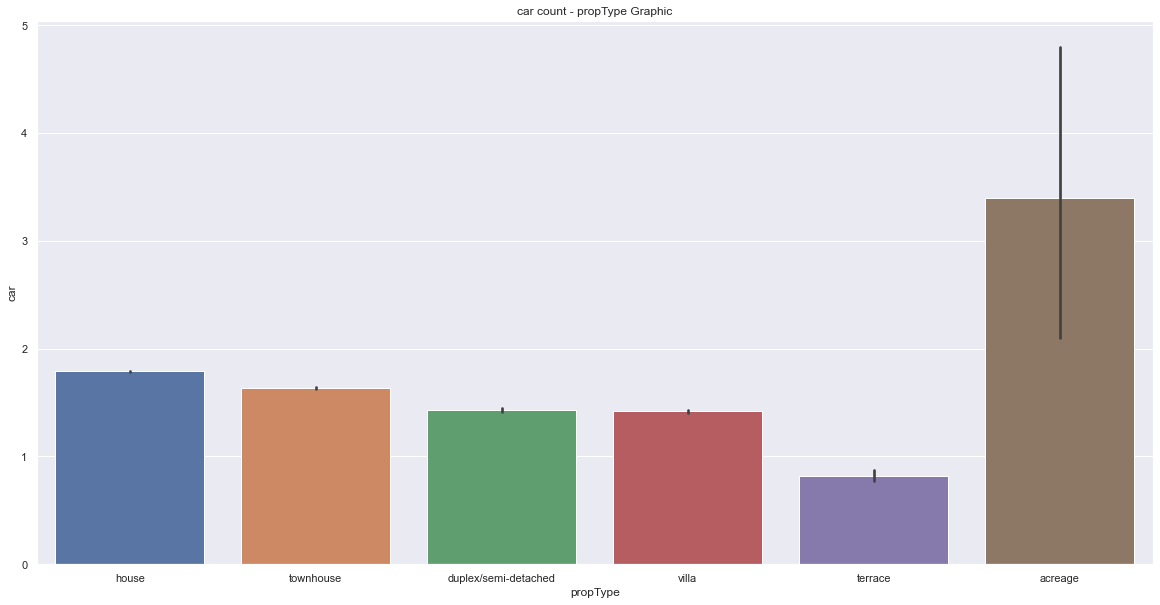

In [223]:
for i in check_num_cols:
    sns.barplot(data=df,x="propType", y =i)
    sns.set(rc={'figure.figsize':(20,10)})
    plt.title(f"{i} count - propType Graphic")
    plt.xlabel("propType")
    plt.ylabel(i)
    plt.show()

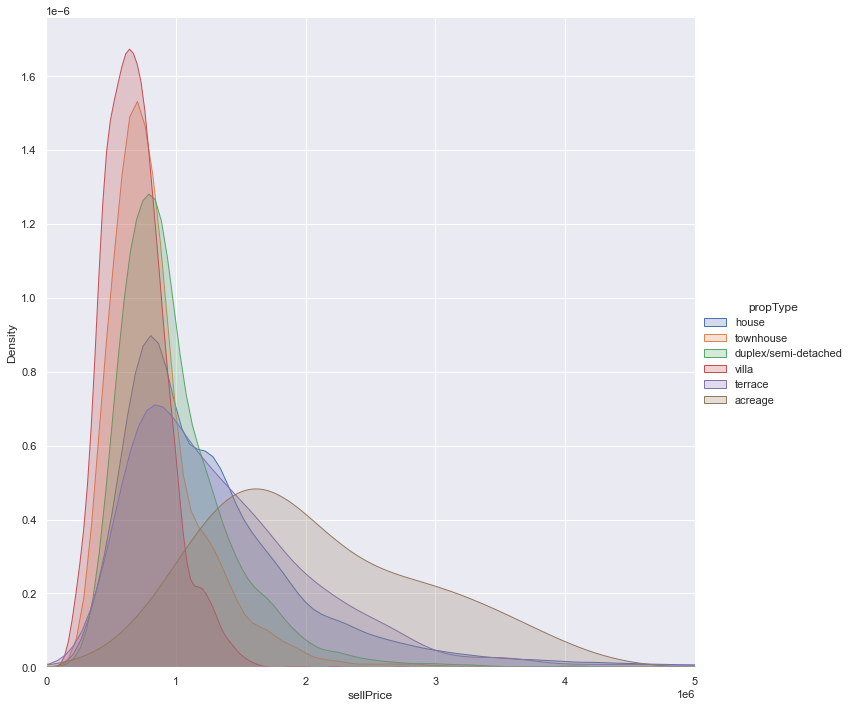

In [224]:
(sns
 .FacetGrid(df,
            hue="propType",
            height= 10,
            xlim=(0,5000000))
 .map(sns.kdeplot,"sellPrice",shade=True)
 .add_legend())

In [225]:
df.groupby("propType")["sellPrice"].mean()

propType
acreage                2062560.00
duplex/semi-detached    993535.75
house                  1345728.42
terrace                1402660.36
townhouse               846816.71
villa                   689488.76
Name: sellPrice, dtype: float64

In [226]:
df.groupby("propType")["sellPrice"].sum()

propType
acreage                     20625600
duplex/semi-detached      6525542797
house                   213694944732
terrace                   1871148921
townhouse                12252591033
villa                     3681869987
Name: sellPrice, dtype: int64

In [227]:

df.groupby("propType")["propType"].count()

propType
acreage                     10
duplex/semi-detached      6568
house                   158795
terrace                   1334
townhouse                14469
villa                     5340
Name: propType, dtype: int64

In [228]:
df.drop(df.loc[df["propType"] == "acreage"].index, axis=0, inplace=True) 
# It was excluded from the data due to the small number of them and the high average price, creating bias.

In [229]:
df.shape

(186506, 8)

In [230]:

df["Year"] = df["Date"].dt.year #Year
df["Month"] = df["Date"].dt.month #Month
df.drop("Date",axis=1, inplace=True)

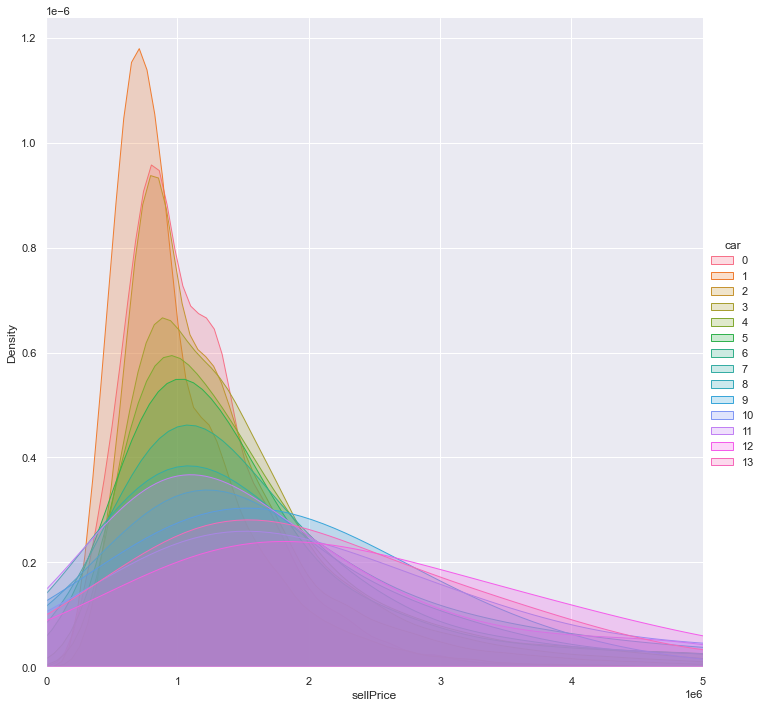

In [231]:
(sns
 .FacetGrid(df,
            hue="car",
            height= 10,
            xlim=(0,5000000))
 .map(sns.kdeplot,"sellPrice",shade=True)
 .add_legend())

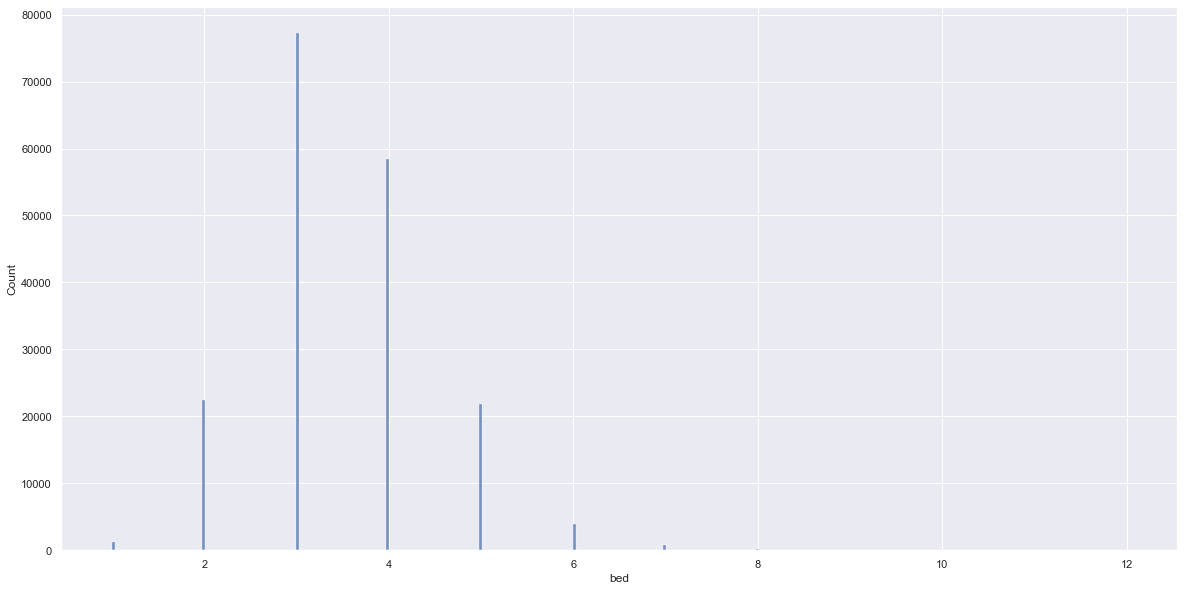

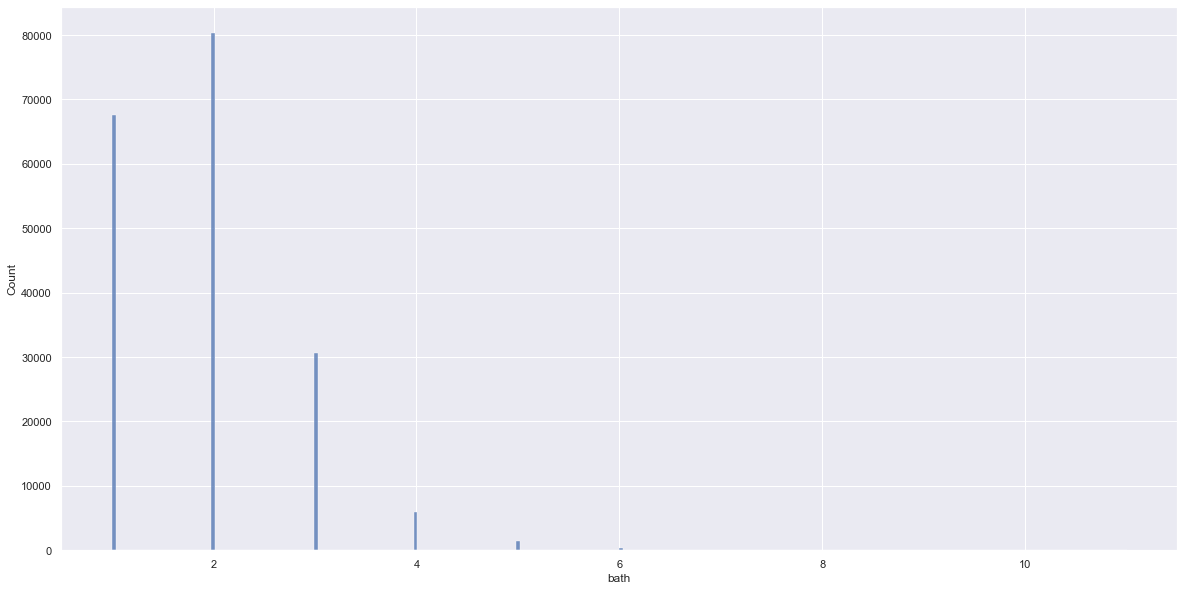

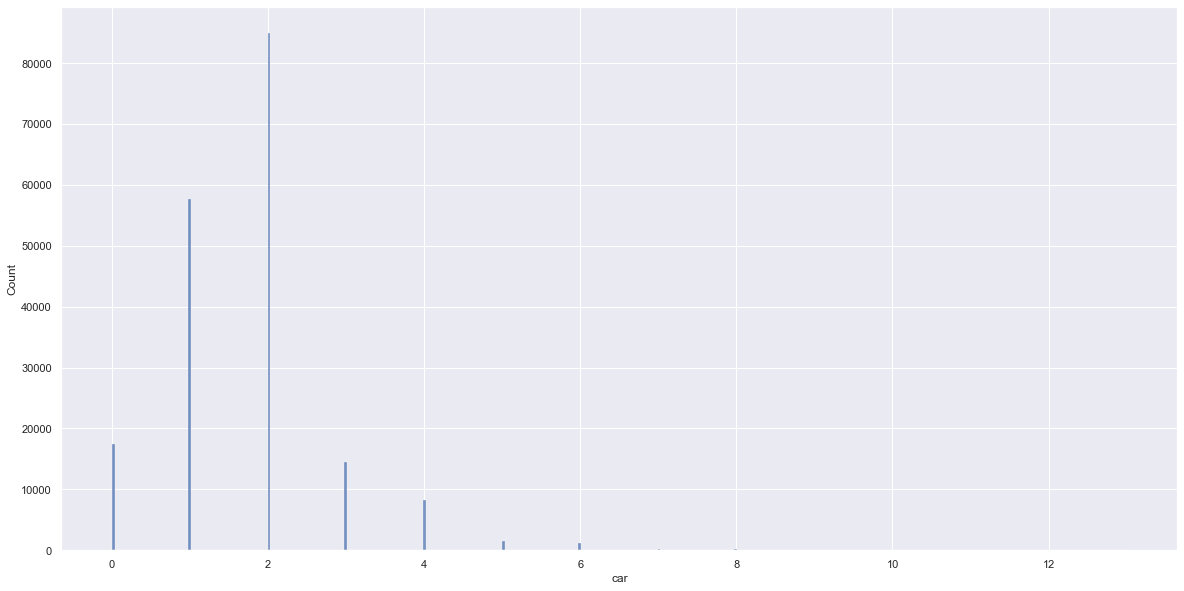

In [232]:
for i in check_num_cols:
    sns.histplot(data=df,x=i)
    plt.show()

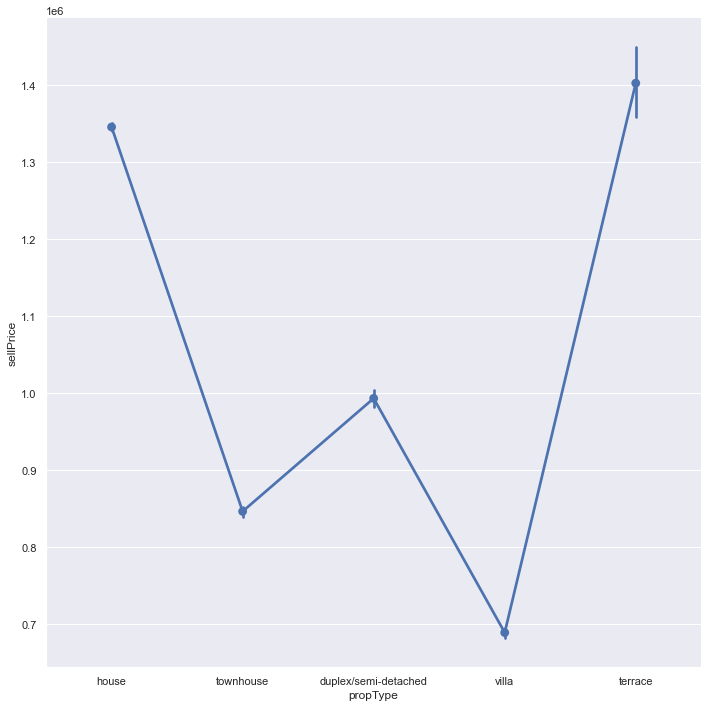

In [233]:
sns.catplot (y = "sellPrice", x = "propType", kind="point", data =df, height=10, aspect=1)
plt.show()

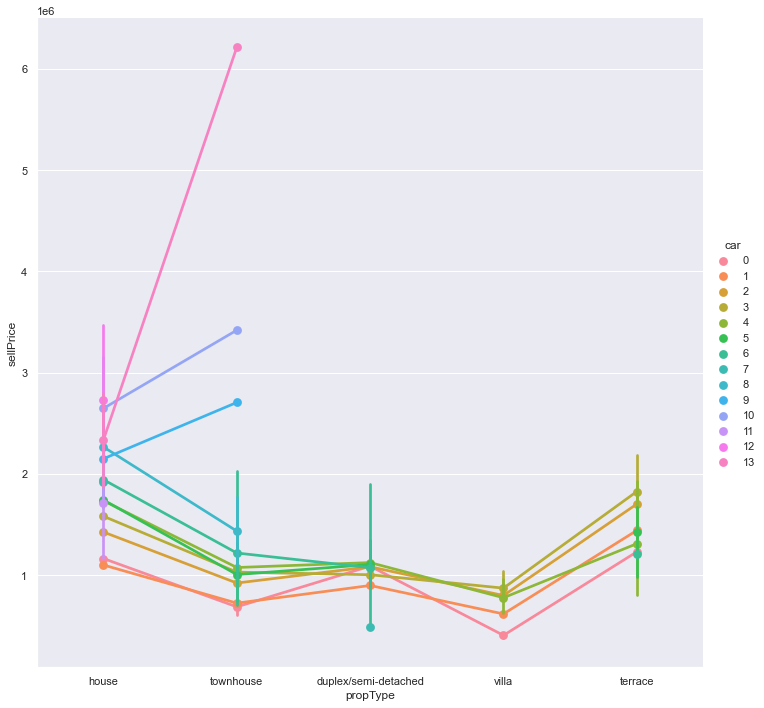

In [234]:
sns.catplot (y = "sellPrice", x = "propType", kind="point", data =df, height=10, aspect=1, hue="car")
plt.show()

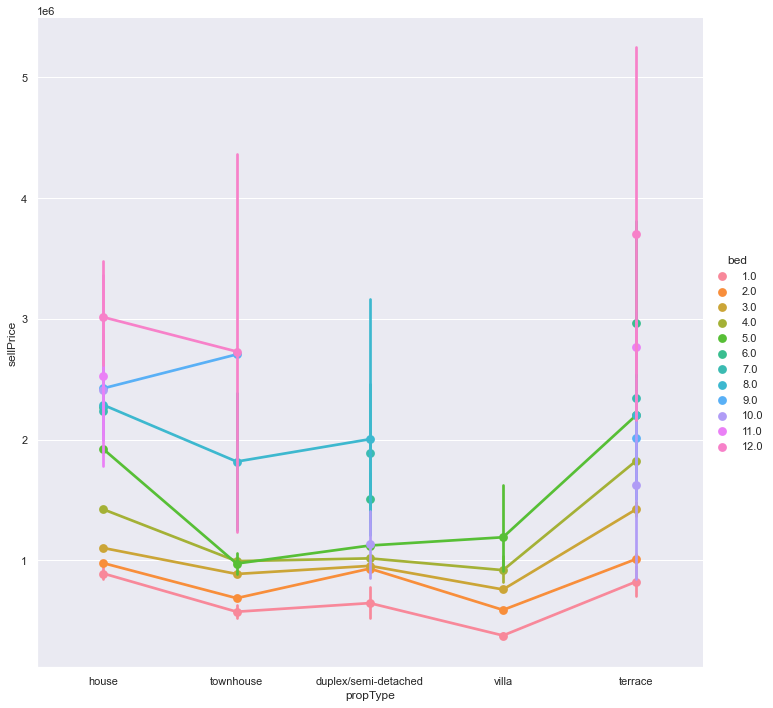

In [235]:
sns.catplot (y = "sellPrice", x = "propType", kind="point", data =df, height=10, aspect=1, hue="bed")
plt.show()

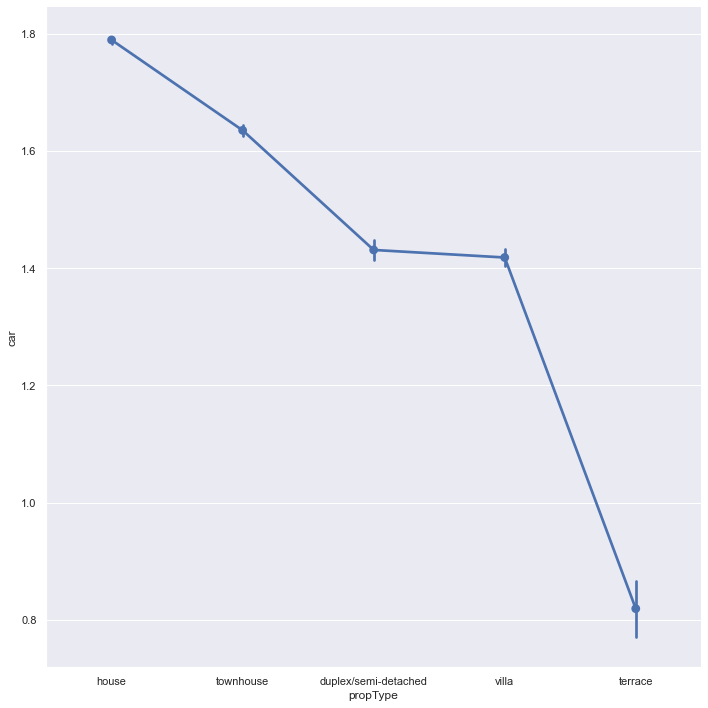

In [236]:
sns.catplot (y = "car", x = "propType", kind="point", data =df, height=10, aspect=1)
plt.show()

In [237]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df["car"], df["bed"])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.395


In [238]:
#from scipy.stats import pearsonr
corr, _ = pearsonr(df["car"], df["sellPrice"])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.212


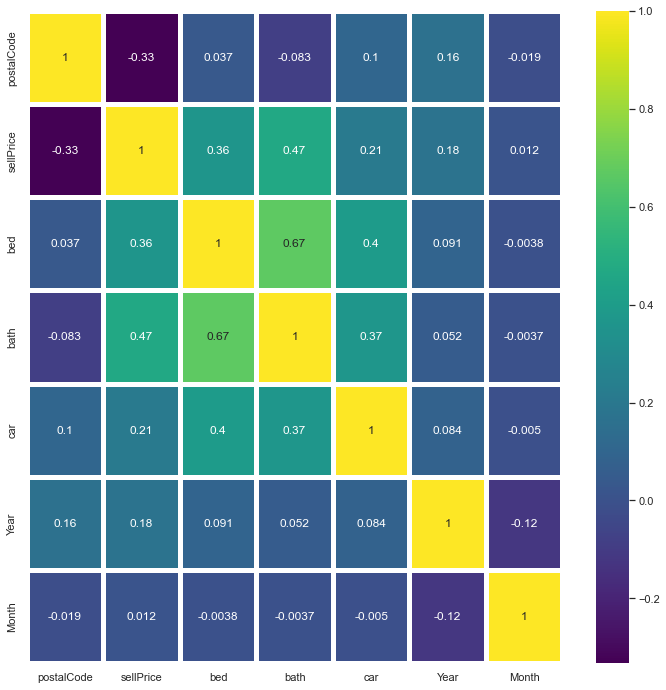

In [239]:
def get_heatmap(df):
  plt.figure(figsize=(12,12))
  sns.heatmap(df.corr(), annot=True, cmap="viridis", linewidths=5)

get_heatmap(df)  # Checking Correlation


In [240]:
df.head()

,suburb,postalCode,sellPrice,bed,bath,car,propType,Year,Month
0,Avalon Beach,2107,1210000,4.00,2,2,house,2019,6
1,Avalon Beach,2107,2250000,4.00,3,4,house,2019,6
2,Whale Beach,2107,2920000,3.00,3,2,house,2019,6
3,Avalon Beach,2107,1530000,3.00,1,2,house,2019,5
4,Whale Beach,2107,8000000,5.00,4,4,house,2019,5


In [241]:
df.groupby("Month")["sellPrice"].mean()

Month
1    1052719.73
2    1276158.71
3    1339645.12
4    1255563.14
5    1279425.20
6    1285912.32
7    1184607.02
8    1270734.41
9    1327678.80
10   1304855.78
11   1325410.50
12   1221231.96
Name: sellPrice, dtype: float64

<AxesSubplot:xlabel='Year'>

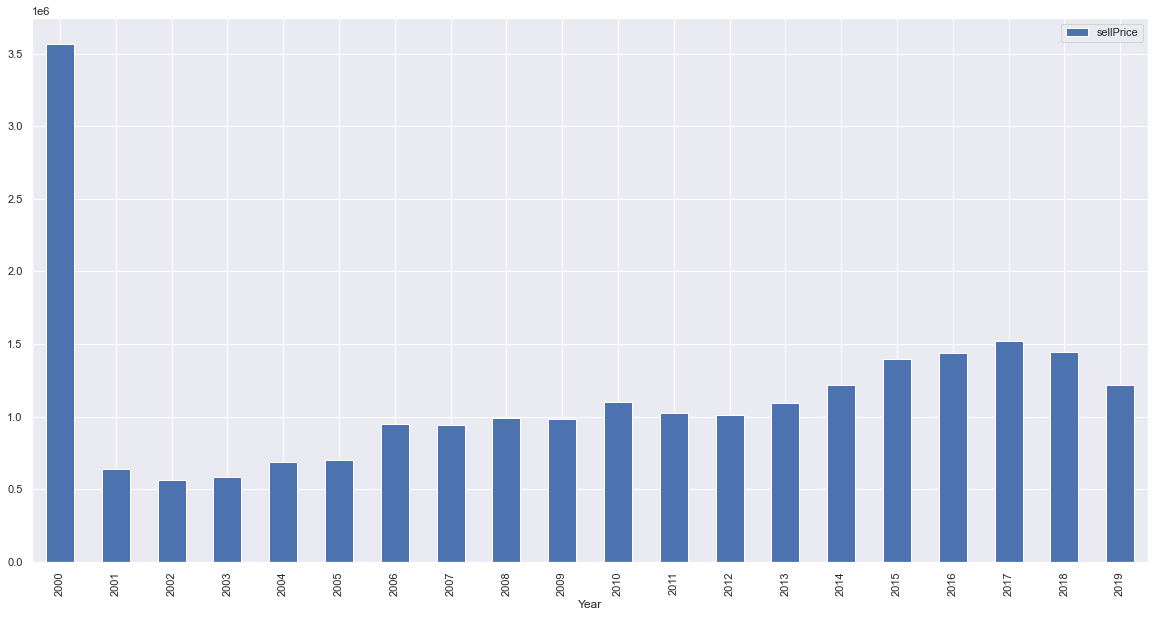

In [242]:
df.groupby("Year").agg({"sellPrice":"mean"}).plot.bar()

In [243]:
df.drop(df.loc[df["Year"] == 2000].index, axis=0, inplace=True) 

In [244]:
df["Year_Quar"] = pd.cut(df["Year"],[2000,2005,2010,2014,2020],labels=["1","2","3","4"])

In [245]:
df.groupby("Year_Quar")["sellPrice"].mean()

Year_Quar
1    684322.90
2   1030551.72
3   1109974.38
4   1431004.57
Name: sellPrice, dtype: float64

In [246]:
df["Season"] = df["sellPrice"]
for i in df.index:
    if ((df["Month"][i] >= 1) and (df["Month"][i] <= 2)) or (df["Month"][i] == 12):
        df["Season"][i] = "Winter"
    if (df["Month"][i] >= 3) and (df["Month"][i] <= 5):
        df["Season"][i] = "Spring"
    if (df["Month"][i] >= 6) and (df["Month"][i] <= 8):
        df["Season"][i] = "Summer"
    if (df["Month"][i] >= 9) and (df["Month"][i] <= 11):
        df["Season"][i] = "Autumn"
df.Season.value_counts()

C:\Users\melih.oznalbant\AppData\Local\Temp\ipykernel_33240\3816021068.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Season"][i] = "Summer"


Spring    53920
Autumn    53312
Summer    44855
Winter    34418
Name: Season, dtype: int64

In [247]:
df.head()

,suburb,postalCode,sellPrice,bed,bath,car,propType,Year,Month,Year_Quar,Season
0,Avalon Beach,2107,1210000,4.00,2,2,house,2019,6,4,Summer
1,Avalon Beach,2107,2250000,4.00,3,4,house,2019,6,4,Summer
2,Whale Beach,2107,2920000,3.00,3,2,house,2019,6,4,Summer
3,Avalon Beach,2107,1530000,3.00,1,2,house,2019,5,4,Spring
4,Whale Beach,2107,8000000,5.00,4,4,house,2019,5,4,Spring


In [248]:
df_month_year_price = df.pivot_table(values="sellPrice", columns="Year", index= "Month")

In [249]:
df_month_year_price = df_month_year_price.fillna(0)

In [250]:
df_month_year_price

Year,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
Month,,,,,,,,,,,,,,,,,,,
1,0.00,0.00,0.00,0.00,542500.00,471142.86,539000.00,890372.64,774101.30,865557.08,951584.44,830705.23,890990.77,1001866.79,1107118.86,1128496.39,1208804.86,1181016.23,1161283.12
2,960000.00,0.00,1170000.00,681000.00,588384.62,953077.78,809863.83,1222199.38,832178.01,1072195.17,1098563.92,956215.60,996512.71,1178829.66,1335781.96,1398018.25,1516049.19,1469192.15,1274336.96
3,896000.00,0.00,0.00,1023571.43,720423.08,680675.00,1089407.67,1029637.66,959649.58,1225041.48,1136909.51,1084471.56,1096107.14,1240321.56,1375018.66,1464999.59,1575442.46,1601615.87,1301525.20
4,463000.00,765000.00,350000.00,640000.00,589578.12,526923.08,1023718.25,1120504.11,940467.14,1053392.58,1070099.91,989302.06,1034257.52,1159080.54,1318667.36,1402904.56,1525359.90,1425167.48,1246400.90
5,0.00,442500.00,0.00,557833.33,1536000.00,955727.27,907643.50,1029347.59,935397.23,1099437.09,1063058.67,1067141.10,1089519.95,1179533.54,1403109.99,1421234.07,1569261.03,1467699.22,1109053.02
6,0.00,485000.00,321000.00,545000.00,747783.33,1663131.58,866233.58,1101909.91,989589.75,1149652.39,1001807.23,989538.23,1079072.68,1209290.20,1446053.59,1430005.35,1534816.85,1479693.93,1163119.42
7,0.00,0.00,587500.00,660000.00,661222.22,1040058.82,787484.62,939465.34,919959.46,945711.16,950475.13,929820.18,1001173.54,1140244.62,1369544.47,1302967.95,1412581.36,1283942.27,1183883.08
8,0.00,0.00,1100000.00,504571.43,598100.00,1696375.00,855808.33,978967.96,936457.69,1068077.57,949197.33,1001818.58,1073181.23,1197948.98,1451360.01,1430129.32,1482888.37,1422665.52,0.00
9,372000.00,0.00,690000.00,934846.15,841300.00,1064833.33,904925.37,1022244.00,1050848.68,1155850.84,988540.78,1031838.66,1134575.72,1272543.58,1468028.84,1487323.99,1577805.71,1521907.88,0.00


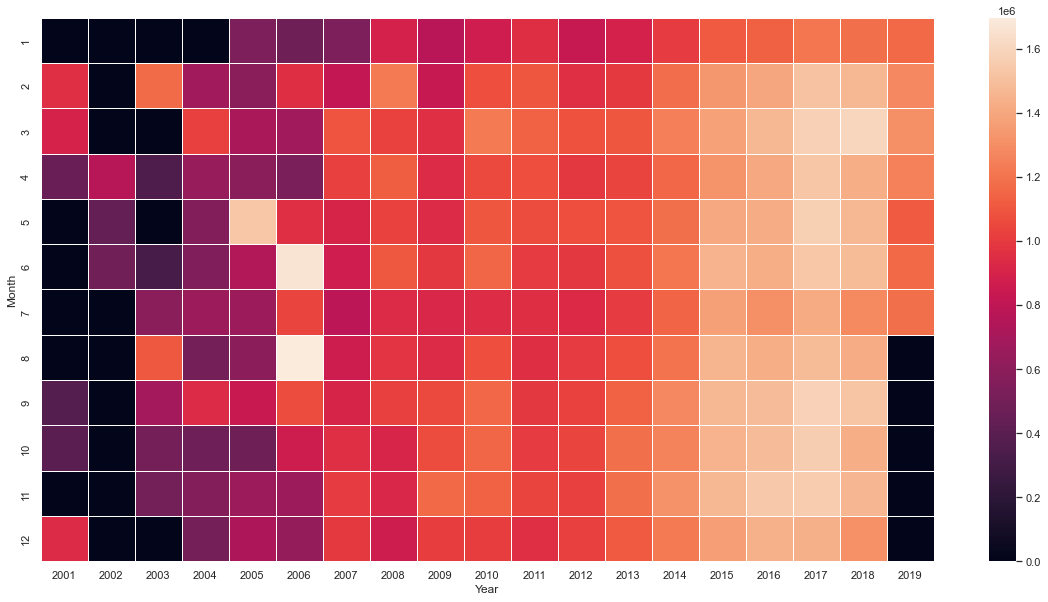

In [251]:
sns.heatmap(df_month_year_price, linewidth=.5)
plt.show()

In [252]:
df.drop(df.loc[df["Year"] == 2019].index, axis=0, inplace=True) #Since it does not include the entire year 2019, the year 2019 has been excluded from the data.

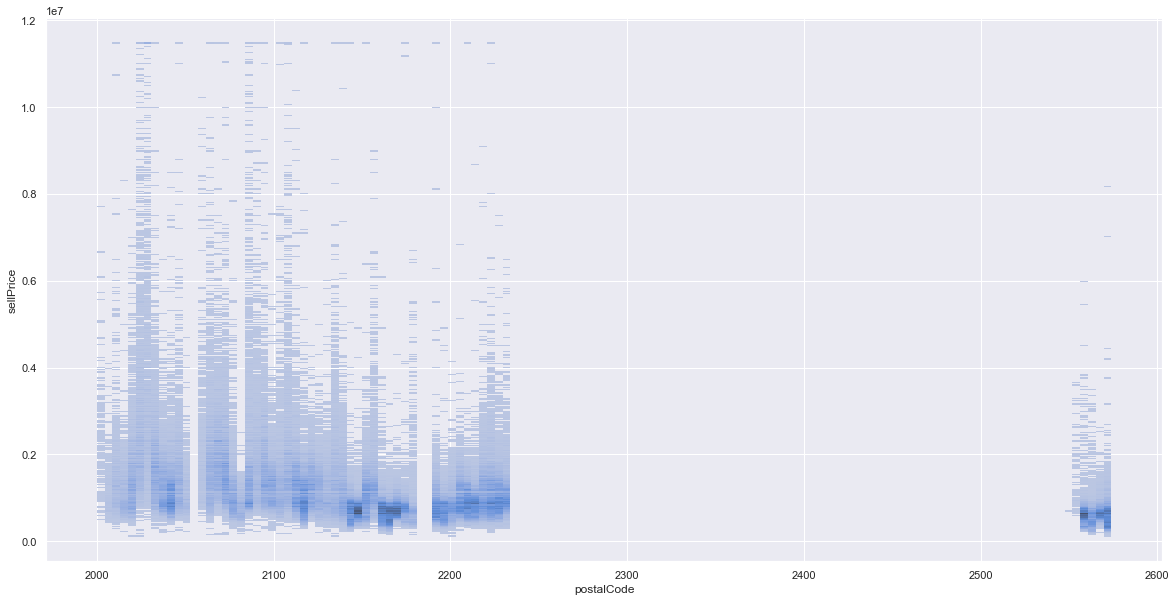

In [253]:
sns.histplot(data=df, x="postalCode", y="sellPrice")
plt.show()

In [254]:

df["PostCode"] = [str(x)[0:2] for x in df["postalCode"]]

In [255]:
df["PostCode"].unique()

array(['21', '20', '25', '22'], dtype=object)

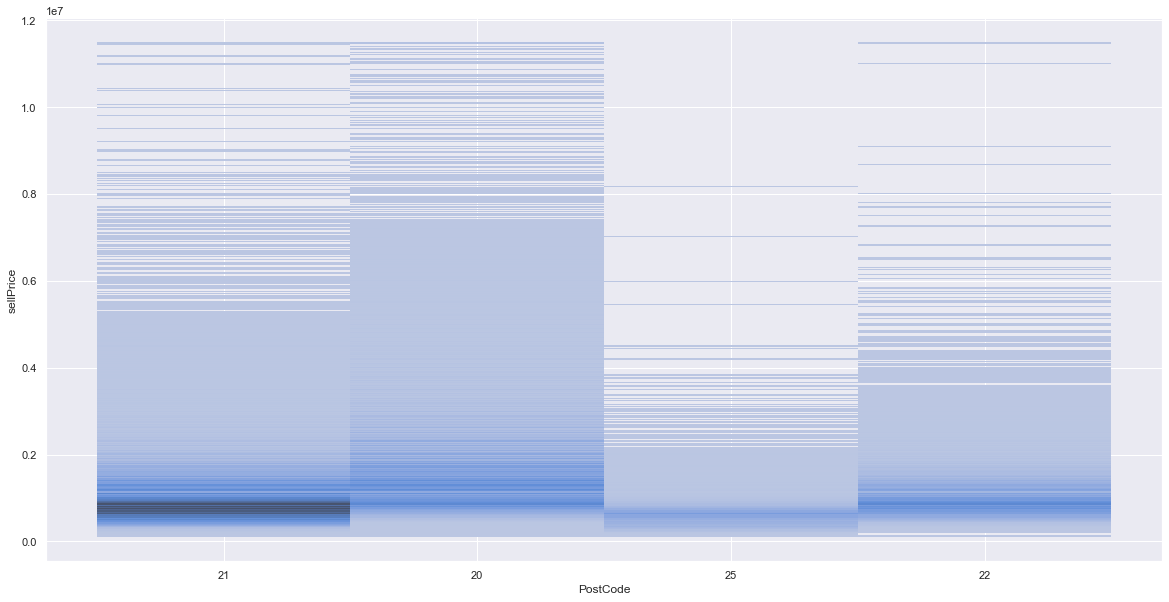

In [256]:
sns.histplot(data=df, x="PostCode", y="sellPrice")
plt.show()

In [257]:
df.drop("postalCode", axis=1, inplace=True)

In [258]:
# Encoding

df.head()

,suburb,sellPrice,bed,bath,car,propType,Year,Month,Year_Quar,Season,PostCode
20,Avalon Beach,1020000,2.00,1,1,house,2018,12,4,Winter,21
21,Avalon Beach,2040000,4.00,2,2,house,2018,12,4,Winter,21
22,Avalon Beach,1359000,4.00,3,2,house,2018,12,4,Winter,21
23,Avalon Beach,1715000,3.00,2,2,house,2018,12,4,Winter,21
24,Bilgola Plateau,1600000,3.00,2,2,house,2018,12,4,Winter,21


In [259]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 178258 entries, 20 to 199503
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   suburb     178258 non-null  object  
 1   sellPrice  178258 non-null  int64   
 2   bed        178258 non-null  float64 
 3   bath       178258 non-null  int64   
 4   car        178258 non-null  int32   
 5   propType   178258 non-null  object  
 6   Year       178258 non-null  int64   
 7   Month      178258 non-null  int64   
 8   Year_Quar  178258 non-null  category
 9   Season     178258 non-null  object  
 10  PostCode   178258 non-null  object  
dtypes: category(1), float64(1), int32(1), int64(4), object(4)
memory usage: 18.5+ MB


In [260]:
df["Year_Quar"] = df["Year_Quar"].astype("O")

In [261]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178258 entries, 20 to 199503
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   suburb     178258 non-null  object 
 1   sellPrice  178258 non-null  int64  
 2   bed        178258 non-null  float64
 3   bath       178258 non-null  int64  
 4   car        178258 non-null  int32  
 5   propType   178258 non-null  object 
 6   Year       178258 non-null  int64  
 7   Month      178258 non-null  int64  
 8   Year_Quar  178258 non-null  object 
 9   Season     178258 non-null  object 
 10  PostCode   178258 non-null  object 
dtypes: float64(1), int32(1), int64(4), object(5)
memory usage: 19.7+ MB


In [262]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [263]:
df = rare_encoder(df,0.001)

In [264]:
for i in df.columns:
    print (f"###### {i} ######")
    print (df[i].value_counts())

###### suburb ######
Rare              18165
Ermington          1205
St Ives            1204
Strathfield        1204
Mosman             1199
                  ...  
Narellan Vale       184
Beverley Park       180
Campbelltown        180
Wentworthville      179
Menai               179
Name: suburb, Length: 310, dtype: int64
###### sellPrice ######
1200000    1578
1100000    1496
1300000    1442
850000     1209
900000     1164
           ... 
4655000       1
1300555       1
1702100       1
1710800       1
1186400       1
Name: sellPrice, Length: 7708, dtype: int64
###### bed ######
3.00     73949
4.00     55696
2.00     21706
5.00     20816
6.00      3729
1.00      1164
7.00       696
8.00       242
9.00        93
12.00       93
10.00       58
11.00       16
Name: bed, dtype: int64
###### bath ######
2     76624
1     64708
3     29336
4      5681
5      1339
6       368
7       104
8        38
11       34
10       18
9         8
Name: bath, dtype: int64
###### car ######
2     80902
1  

In [265]:
df.drop(df.loc[df["suburb"] == "Rare"].index, axis=0, inplace=True) 

In [267]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160093 entries, 20 to 199495
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   suburb     160093 non-null  object 
 1   sellPrice  160093 non-null  int64  
 2   bed        160093 non-null  float64
 3   bath       160093 non-null  int64  
 4   car        160093 non-null  int32  
 5   propType   160093 non-null  object 
 6   Year       160093 non-null  int64  
 7   Month      160093 non-null  int64  
 8   Year_Quar  160093 non-null  object 
 9   Season     160093 non-null  object 
 10  PostCode   160093 non-null  object 
dtypes: float64(1), int32(1), int64(4), object(5)
memory usage: 14.0+ MB


In [268]:
df.shape

(160093, 11)

In [269]:
apply_label_encode = [col for col in df.columns if df[col].dtypes=="O"]

In [270]:
apply_label_encode

['suburb', 'propType', 'Year_Quar', 'Season', 'PostCode']

In [271]:
apply_label_encode = [col for col in apply_label_encode if col not in ["Season","PostCode","suburb","propType"]]

In [272]:
def label_encoder(dataframe, app_label_encode):
    labelencoder = LabelEncoder()
    dataframe[app_label_encode] = labelencoder.fit_transform(dataframe[app_label_encode])
    return dataframe

In [273]:
for col in apply_label_encode:
    label_encoder(df, col)

In [274]:
df.head()

,suburb,sellPrice,bed,bath,car,propType,Year,Month,Year_Quar,Season,PostCode
20,Avalon Beach,1020000,2.00,1,1,house,2018,12,3,Winter,21
21,Avalon Beach,2040000,4.00,2,2,house,2018,12,3,Winter,21
22,Avalon Beach,1359000,4.00,3,2,house,2018,12,3,Winter,21
23,Avalon Beach,1715000,3.00,2,2,house,2018,12,3,Winter,21
24,Bilgola Plateau,1600000,3.00,2,2,house,2018,12,3,Winter,21


In [275]:
df.head()

,suburb,sellPrice,bed,bath,car,propType,Year,Month,Year_Quar,Season,PostCode
20,Avalon Beach,1020000,2.00,1,1,house,2018,12,3,Winter,21
21,Avalon Beach,2040000,4.00,2,2,house,2018,12,3,Winter,21
22,Avalon Beach,1359000,4.00,3,2,house,2018,12,3,Winter,21
23,Avalon Beach,1715000,3.00,2,2,house,2018,12,3,Winter,21
24,Bilgola Plateau,1600000,3.00,2,2,house,2018,12,3,Winter,21


In [276]:
df_mdl = df.copy()

In [277]:
ss = [col for col in df.columns if (df[col].dtypes in [int,"int32","int64",float,"float32","float64"]) and (df[col].nunique()>5)]

In [278]:
ss.remove("sellPrice")

In [279]:
ss

['bed', 'bath', 'car', 'Year', 'Month']

In [280]:
for i in ss:
    df_mdl[i] = StandardScaler().fit_transform(df[[i]])

In [281]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns = categorical_cols, drop_first=drop_first)
    return dataframe

In [282]:
cat_ohe_cols = [col for col in df_mdl.columns if df_mdl[col].dtypes=="O"]

In [283]:
cat_ohe_cols

['suburb', 'propType', 'Season', 'PostCode']

In [284]:
cat_ohe_cols.append("Month")

In [285]:
cat_ohe_cols.append("Year_Quar")

In [286]:
df_mdl.head()

,suburb,sellPrice,bed,bath,car,propType,Year,Month,Year_Quar,Season,PostCode
20,Avalon Beach,1020000,-1.48,-1.01,-0.67,house,1.37,1.55,3,Winter,21
21,Avalon Beach,2040000,0.50,0.11,0.25,house,1.37,1.55,3,Winter,21
22,Avalon Beach,1359000,0.50,1.24,0.25,house,1.37,1.55,3,Winter,21
23,Avalon Beach,1715000,-0.49,0.11,0.25,house,1.37,1.55,3,Winter,21
24,Bilgola Plateau,1600000,-0.49,0.11,0.25,house,1.37,1.55,3,Winter,21


In [287]:
df_mdl = one_hot_encoder(df_mdl, cat_ohe_cols, drop_first=True)

In [288]:
# Machine Learning Model

X = df_mdl.drop('sellPrice', axis=1)

y = df_mdl[["sellPrice"]]

In [289]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1) 

In [290]:
X_train.shape

(128074, 336)

In [291]:
X_test.shape

(32019, 336)

In [292]:
df_mdl.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160093 entries, 20 to 199495
Columns: 337 entries, sellPrice to Year_Quar_3
dtypes: float64(4), int64(1), uint8(332)
memory usage: 58.0 MB


In [293]:
reg_model = LinearRegression().fit(X_train, y_train)

In [294]:
# Tahmin Başarısını Değerlendirme
y_pred = reg_model.predict(X_train)

In [295]:
MSE_Train = (mean_squared_error(y_train, y_pred))

In [296]:
MSE_Train

280414159362.311

In [297]:
Train_R2 = reg_model.score(X_train, y_train)

In [298]:
Train_R2

0.6509455572959293

In [299]:
y_pred = reg_model.predict(X_test)
MSE_Test = mean_squared_error(y_test, y_pred)

In [300]:
RMSE = np.sqrt(MSE_Test)

In [301]:
RMSE

545591.499961862

In [302]:
MAE = mean_absolute_error(y_test, y_pred)

In [303]:
MAE

298881.2675968444

In [304]:
y_test.mean()

sellPrice   1284522.21
dtype: float64

In [305]:
MAE / y_test.mean()

sellPrice   0.23
dtype: float64

In [306]:
MSE_Test

297670084830.63446

In [307]:
Test_R2 = reg_model.score(X_test, y_test)

In [308]:
Test_R2

0.6401130373697814

In [309]:
df_check = y_test.copy()

In [310]:
df_check.columns=["y_test"]

In [311]:
df_check["y_pred"] = y_pred

In [312]:
df_check.head()

,y_test,y_pred
164973,1150000,898330.63
17367,829000,597253.43
71968,850000,995143.97
18451,977000,1166476.94
158517,1002000,1082131.76


<AxesSubplot:xlabel='y_test', ylabel='y_pred'>

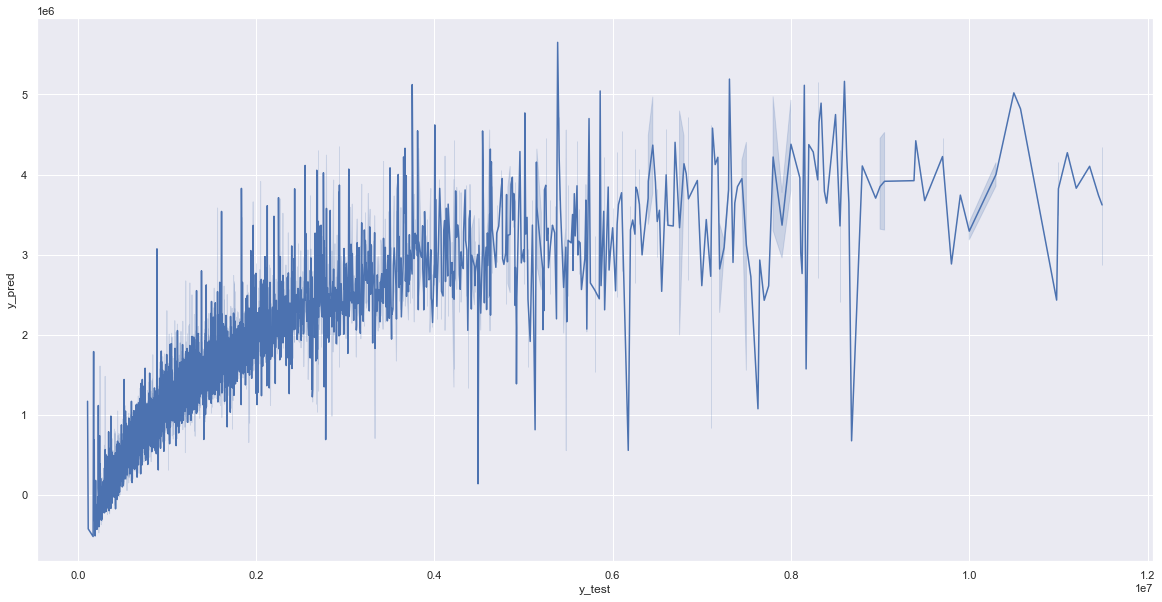

In [313]:
sns.lineplot(x="y_test",y="y_pred",data=df_check)

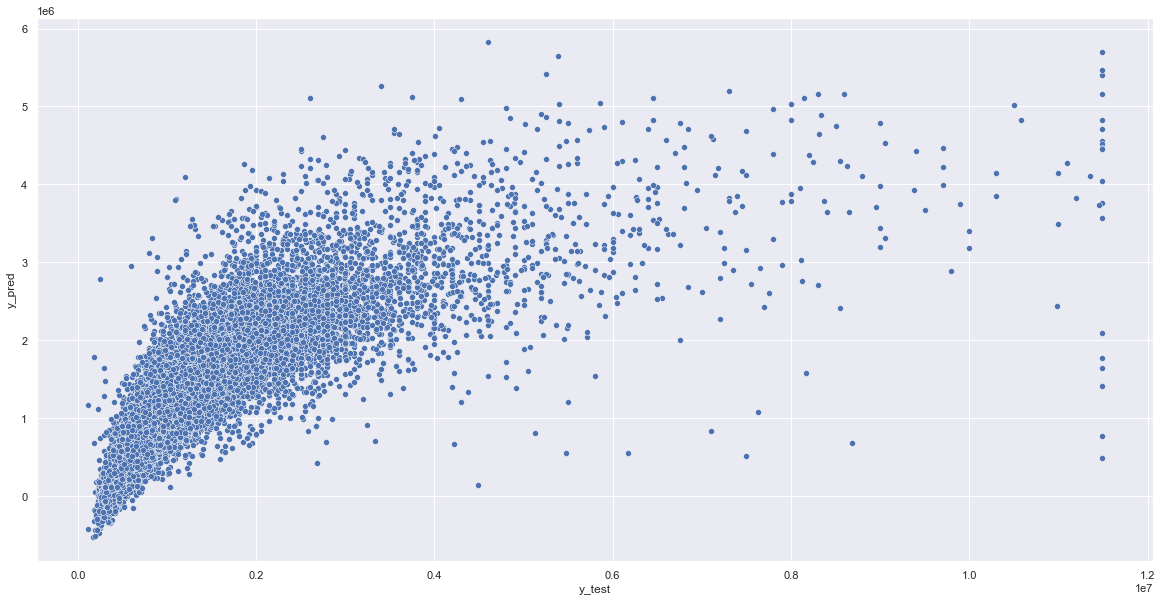

In [314]:
sns.scatterplot(x="y_test",y="y_pred",data=df_check)
plt.show()

In [315]:
df["sellPrice"].mean()

1281390.9728033082

In [316]:
df["sellPrice"].std()

898951.9936511058

In [317]:
RMSE

545591.499961862

In [318]:
df["sellPrice"].std() > RMSE


True

In [319]:
df["sellPrice"].std() > MAE


True

In [320]:
RMSE / df["sellPrice"].mean()

0.42578066456037816

In [321]:
df["sellPrice"].describe().T

count     160093.00
mean     1281390.97
std       898951.99
min       110000.00
25%       750000.00
50%      1045000.00
75%      1525108.00
max     11490000.00
Name: sellPrice, dtype: float64

In [322]:
df_check["mean_check"] = (df_check["y_test"]-df_check["y_pred"]) / df_check["y_test"]

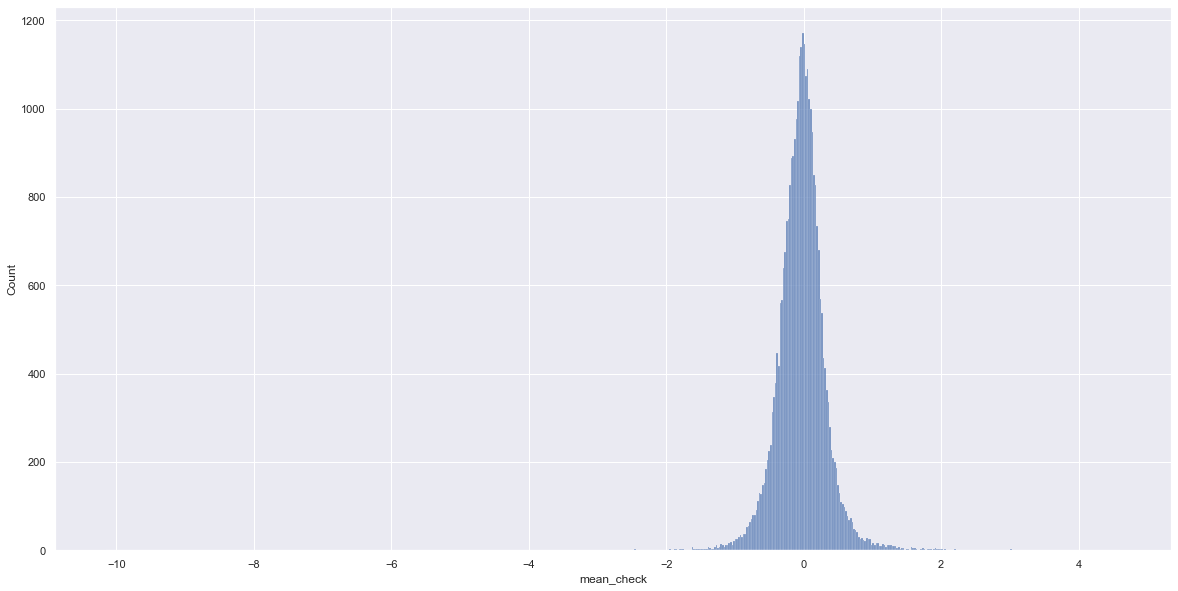

In [323]:
sns.histplot(data=df_check,x="mean_check")
plt.show()

In [324]:
df_check.head()

,y_test,y_pred,mean_check
164973,1150000,898330.63,0.22
17367,829000,597253.43,0.28
71968,850000,995143.97,-0.17
18451,977000,1166476.94,-0.19
158517,1002000,1082131.76,-0.08


In [325]:
high_err = df_check[df_check["mean_check"]>0.1].index

In [326]:
df_err = df.loc[high_err]

In [327]:
df_err.head()

,suburb,sellPrice,bed,bath,car,propType,Year,Month,Year_Quar,Season,PostCode
164973,Kirrawee,1150000,2.00,1,1,house,2017,12,3,Winter,22
17367,Frenchs Forest,829000,3.00,1,2,house,2011,10,2,Autumn,20
65066,Brighton-Le-Sands,970000,2.00,2,2,duplex/semi-detached,2014,11,2,Autumn,22
42844,Granville,545000,2.00,1,1,house,2013,12,2,Winter,21
29442,Bexley,760000,2.00,1,1,duplex/semi-detached,2014,8,2,Summer,22


In [328]:
df_err["mean_check"] = df_check.loc[df_check["mean_check"]>0.1,"mean_check"]

In [329]:
df_err.head()

,suburb,sellPrice,bed,bath,car,propType,Year,Month,Year_Quar,Season,PostCode,mean_check
164973,Kirrawee,1150000,2.00,1,1,house,2017,12,3,Winter,22,0.22
17367,Frenchs Forest,829000,3.00,1,2,house,2011,10,2,Autumn,20,0.28
65066,Brighton-Le-Sands,970000,2.00,2,2,duplex/semi-detached,2014,11,2,Autumn,22,0.14
42844,Granville,545000,2.00,1,1,house,2013,12,2,Winter,21,0.54
29442,Bexley,760000,2.00,1,1,duplex/semi-detached,2014,8,2,Summer,22,0.62


In [330]:
df_err.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10027 entries, 164973 to 53030
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   suburb      10027 non-null  object 
 1   sellPrice   10027 non-null  int64  
 2   bed         10027 non-null  float64
 3   bath        10027 non-null  int64  
 4   car         10027 non-null  int32  
 5   propType    10027 non-null  object 
 6   Year        10027 non-null  int64  
 7   Month       10027 non-null  int64  
 8   Year_Quar   10027 non-null  int32  
 9   Season      10027 non-null  object 
 10  PostCode    10027 non-null  object 
 11  mean_check  10027 non-null  float64
dtypes: float64(2), int32(2), int64(4), object(4)
memory usage: 940.0+ KB


In [331]:
num_cols = [col for col in df_err if df_err[col].dtypes != "O"]

In [332]:
num_cols

['sellPrice', 'bed', 'bath', 'car', 'Year', 'Month', 'Year_Quar', 'mean_check']

In [333]:
cat_cols = [col for col in df_err if df_err[col].dtypes not in num_cols]

In [334]:
for i in num_cols:
    print(f"########## {i} ##########")
    print(df_err.groupby(i).agg({"mean_check":["mean","sum","count"]}))

########## sellPrice ##########
          mean_check            
                mean   sum count
sellPrice                       
117500          4.61  4.61     1
172500          4.01  4.01     1
181000          2.76  2.76     1
187500          1.94  1.94     1
189000          2.00  2.00     1
...              ...   ...   ...
11100000        0.62  0.62     1
11200000        0.66  0.66     1
11350000        0.64  0.64     1
11450000        0.67  0.67     1
11490000        0.68 13.01    19

[2269 rows x 3 columns]
########## bed ##########
      mean_check              
            mean     sum count
bed                           
1.00        0.66   48.61    74
2.00        0.46  786.98  1707
3.00        0.33 1603.90  4876
4.00        0.24  555.37  2274
5.00        0.26  237.80   904
6.00        0.31   48.32   155
7.00        0.31    6.78    22
8.00        0.26    3.15    12
9.00        0.48    0.95     2
12.00       0.33    0.33     1
########## bath ##########
     mean_check          

In [335]:
for i in num_cols:
    print(f"########## {i} ##########")
    print(df_err.groupby(col).agg({"mean_check":["mean","sum","count"]}))

########## sellPrice ##########
          mean_check              
                mean     sum count
Year_Quar                         
0               0.52   13.45    26
1               0.45  715.32  1602
2               0.36 1551.24  4258
3               0.24 1012.17  4141
########## bed ##########
          mean_check              
                mean     sum count
Year_Quar                         
0               0.52   13.45    26
1               0.45  715.32  1602
2               0.36 1551.24  4258
3               0.24 1012.17  4141
########## bath ##########
          mean_check              
                mean     sum count
Year_Quar                         
0               0.52   13.45    26
1               0.45  715.32  1602
2               0.36 1551.24  4258
3               0.24 1012.17  4141
########## car ##########
          mean_check              
                mean     sum count
Year_Quar                         
0               0.52   13.45    26
1             